# Denison DA210/CS181 Project Deliverable #3: Data Storage and Analysis

### Authors: Ashwin Krishnamurthy, Lam Do

Central Question: What countries have the best public and professional film success rates?

We will answer this question by analyzing three tables with information about countries (except from the US), the number of films the country produced, the number of box office tickets it sold, and the number of awards it received. Additionally, after some review, we decided to add in the data sets indicators and countries from the textbook, with an attempt to do something interesting with pop and region.

---

In [283]:
import os
import os.path
import pandas as pd
from lxml import etree
import json
import sqlalchemy as sa
import matplotlib.pyplot as pyplot

### I. Introduce SQL Database

We will perform data analysis using the following database. There are 2 tables: `countries` and `films`. The relationship between them is a one-to-one relationship.

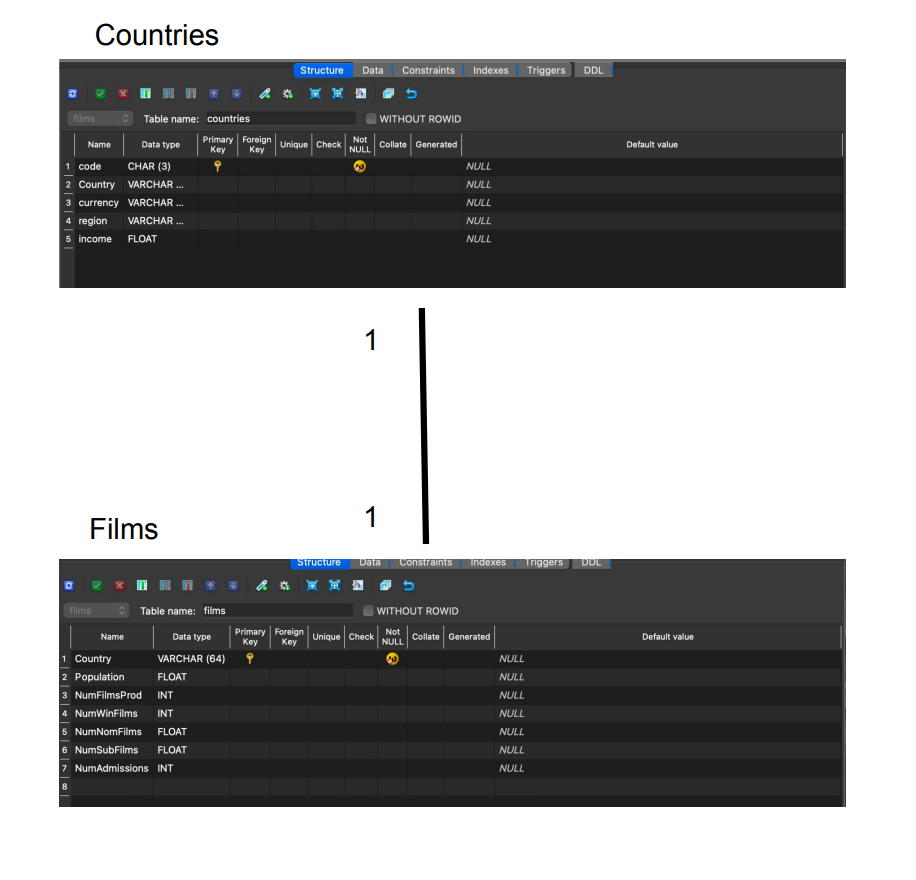

In [284]:
from IPython.display import Image
Image("figs/diagram.png", width=600, height=600)

In the following code cells, we are building a connection to `films.db`, which contains the two tables we have on the diagram above.

In [285]:
def getsqlite_creds(dirname=".",filename="creds.json",source="sqlite"):
    """ Using directory and filename parameters, open a credentials file
        and obtain the two parts needed for a connection string to
        a local provider using the "sqlite" dictionary within
        an outer dictionary.  
        
        Return a scheme and a dbfile
    """
    assert os.path.isfile(os.path.join(dirname, filename))
    with open(os.path.join(dirname, filename)) as f:
        D = json.load(f)
    sqlite = D[source]
    return sqlite["scheme"], sqlite["dbdir"], sqlite["database"]

In [286]:
def buildConnectionString(source="sqlite"):
    scheme, dbdir, database = getsqlite_creds(source=source)
    template = '{}:///{}/{}.db'
    return template.format(scheme, dbdir, database)

In [287]:
# Build the conection string
cstring = buildConnectionString("sqlite")
print("Connection string:", cstring)

# Connect to the database
engine = sa.create_engine(cstring)
connection = engine.connect()

Connection string: sqlite:///dbfiles/films.db


### II. Data analysis

We calculate the public success of the film industry for each country using the number of admissions divided by population. These values indicate the ratio of box office tickets sold over a population of the country. Number of admissions and population are both stored in millions. It is really interesting that each person in France goes to the cinema three times a year on average!

In [288]:
query = """
SELECT Country, NumAdmissions/Population AS PubSuccess
FROM films
ORDER BY pubSuccess DESC
"""
df_pub = pd.read_sql_query(query, con=connection)
df_pub

,Country,PubSuccess
0,France,3.064733
1,Mexico,2.759918
2,United Kingdom,2.667683
3,Japan,1.527679
4,China,1.196814
5,India,1.143358
6,Brazil,0.852396


Here, we bring in more variables (region and income) by joining the current table with countries. We can now group these countries into regions or incomes. We decide to go with region.

In [289]:
query = """
SELECT Country, region, income, PubSuccess
FROM countries INNER JOIN (SELECT Country, NumAdmissions/Population AS pubSuccess FROM films) USING (Country)
ORDER BY pubSuccess DESC
"""
df_total_pub = pd.read_sql_query(query, con=connection)
df_total_pub

,Country,region,income,pubSuccess
0,France,Europe & Central Asia,High income,3.064733
1,Mexico,Latin America & Caribbean,Upper middle income,2.759918
2,United Kingdom,Europe & Central Asia,High income,2.667683
3,Japan,East Asia & Pacific,High income,1.527679
4,China,East Asia & Pacific,Upper middle income,1.196814
5,India,South Asia,Lower middle income,1.143358
6,Brazil,Latin America & Caribbean,Upper middle income,0.852396


In [290]:
query = """
SELECT region, AVG(pubSuccess) as PubSuccess
FROM countries INNER JOIN (SELECT Country, NumAdmissions/Population AS pubSuccess FROM films) USING (Country)
GROUP BY region
"""
df_region_pub = pd.read_sql_query(query, con=connection)
df_region_pub

,region,PubSuccess
0,East Asia & Pacific,1.362247
1,Europe & Central Asia,2.866208
2,Latin America & Caribbean,1.806157
3,South Asia,1.143358


In the following code cells, we are repeating the exact same thing we did above. The only difference is that we are now analyzing the professional success, indicated by the number of nominated films over number of submitted films for professional films awards.

In [291]:
query = """
SELECT Country, NumNomFilms/NumSubFilms AS ProSuccess
FROM films
ORDER BY proSuccess DESC
"""
df_pro = pd.read_sql_query(query, con=connection)
df_pro

,Country,ProSuccess
0,France,0.585714
1,Japan,0.246377
2,Mexico,0.163636
3,United Kingdom,0.105263
4,Brazil,0.076923
5,China,0.055556
6,India,0.054545


In [292]:
query = """
SELECT Country, region, income, ProSuccess
FROM countries INNER JOIN (SELECT Country, NumNomFilms/NumSubFilms AS proSuccess FROM films) USING(Country)
ORDER BY proSuccess DESC
"""
df_total_pro = pd.read_sql_query(query, con=connection)
df_total_pro

,Country,region,income,proSuccess
0,France,Europe & Central Asia,High income,0.585714
1,Japan,East Asia & Pacific,High income,0.246377
2,Mexico,Latin America & Caribbean,Upper middle income,0.163636
3,United Kingdom,Europe & Central Asia,High income,0.105263
4,Brazil,Latin America & Caribbean,Upper middle income,0.076923
5,China,East Asia & Pacific,Upper middle income,0.055556
6,India,South Asia,Lower middle income,0.054545


In [293]:
query = """
SELECT region, AVG(proSuccess) as ProSuccess
FROM countries INNER JOIN (SELECT Country,  NumNomFilms/NumSubFilms AS proSuccess FROM films) USING (Country)
GROUP BY region
"""
df_region_pro = pd.read_sql_query(query, con=connection)
df_region_pro

,region,ProSuccess
0,East Asia & Pacific,0.150966
1,Europe & Central Asia,0.345489
2,Latin America & Caribbean,0.120280
3,South Asia,0.054545


--- 
### III. Visualization
Now that we have a lot of interesting data, let's visualize them!

In [294]:
country = df_pub["Country"]
PubSuccess = df_pub["PubSuccess"]

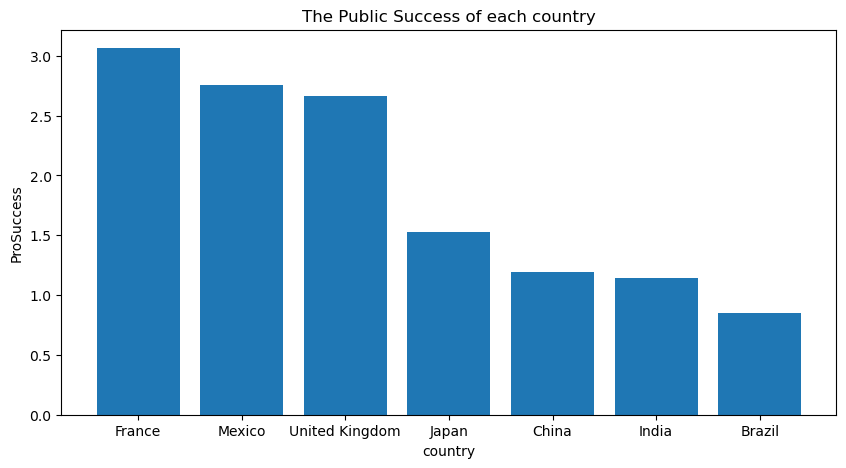

In [295]:
f = pyplot.figure(figsize = (10, 5))
pyplot.bar(country, PubSuccess)
pyplot.xlabel("country")
pyplot.ylabel("ProSuccess")
pyplot.title("The Public Success of each country")
pyplot.show()

In [296]:
country = df_pro["Country"]
ProSuccess = df_pro["ProSuccess"]

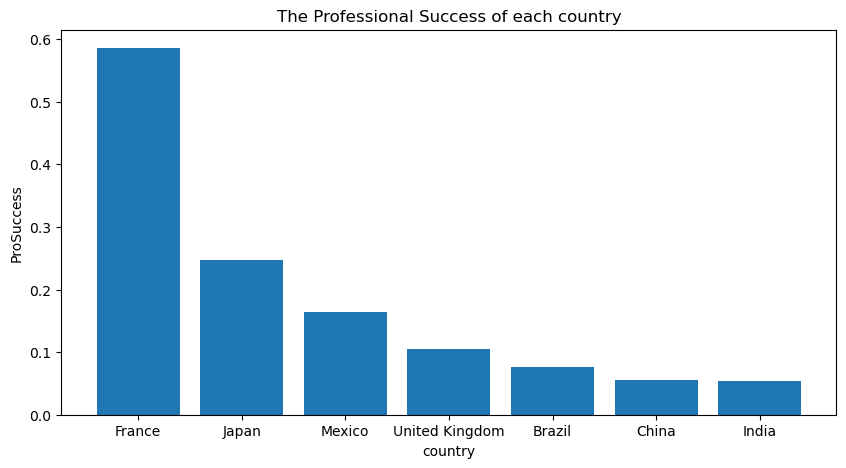

In [297]:
f = pyplot.figure(figsize = (10, 5))
pyplot.bar(country, ProSuccess)
pyplot.xlabel("country")
pyplot.ylabel("ProSuccess")
pyplot.title("The Professional Success of each country")
pyplot.show()

In [298]:
region = df_region_pub["region"]
PubSuccess = df_region_pub["PubSuccess"]

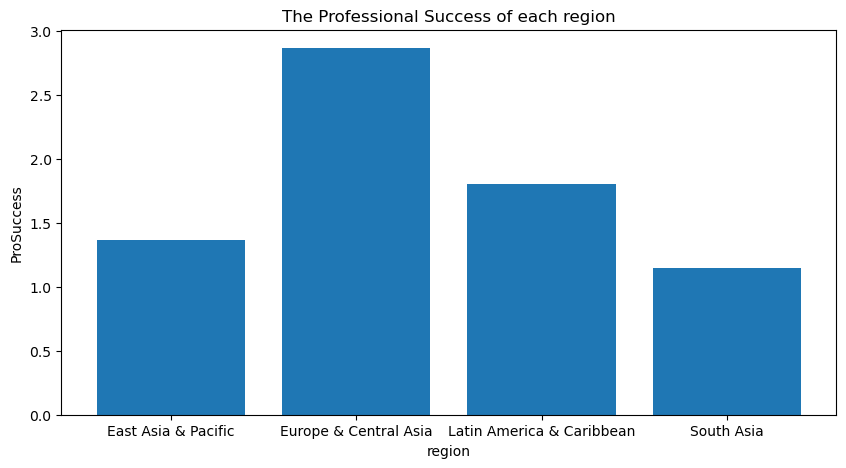

In [299]:
f = pyplot.figure(figsize = (10, 5))
pyplot.bar(region, PubSuccess)
pyplot.xlabel("region")
pyplot.ylabel("ProSuccess")
pyplot.title("The Professional Success of each region")
pyplot.show()

In [300]:
region = df_region_pro["region"]
ProSuccess = df_region_pro["ProSuccess"]

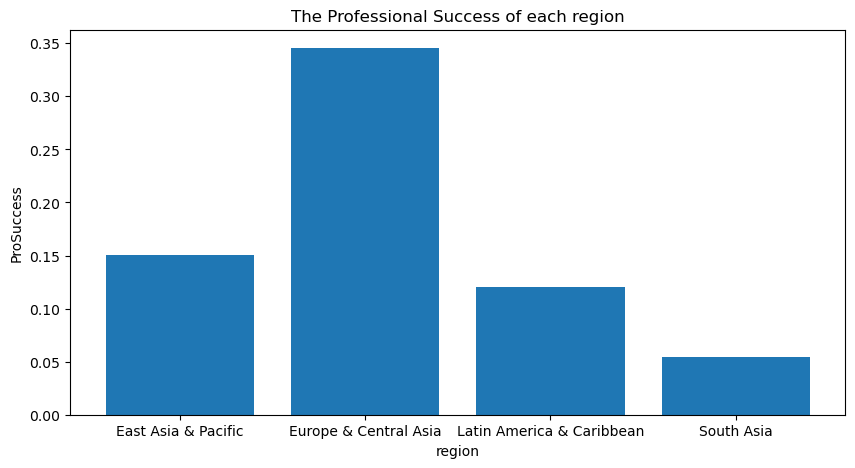

In [301]:
f = pyplot.figure(figsize = (10, 5))
pyplot.bar(region, ProSuccess)
pyplot.xlabel("region")
pyplot.ylabel("ProSuccess")
pyplot.title("The Professional Success of each region")
pyplot.show()

### IV. Conclusion
Overall, the film industry in France is most successful in terms of both publicity and professionality. French audience certainly support their film industry very well and French film producers are globally recognized.

Mexican, UK, and Japanese film industry ranks quite well (all on the upper half) in both aspects.

Brazil holds the lowest public success but exceeds the professional success rate of China and India

We were surprised by this result because we anticipated India to be much more publicly successful, as they produce a lot of films and Bollywood is so well-known! Turns out, the overwhelmingly high population in China and India place them in the lower scale of public success compared to other countries. Their films are not nominated as often, leading in their lowest rank when it comes to professional success. This is also perplexing for us to think about, as quality of films from China and India are arguably good. There could some criteria that explain which countries get film awards that we might have not thought about.

